In [ ]:
# pip install -U pip setuptools wheel
# pip install -U spacy
# python -m spacy download en_core_web_trf

import regex, os, sys
import numpy as np
import pandas as pd

from utils import utils

In [ ]:
# DATA = 'databricks-dolly-15k.jsonl'
# d_data = pd.read_json(DATA, lines=True)

In [ ]:
DATA_FILE = 'dolly_data_paraphrase-MiniLM-L6-v2.parquet' # 'dolly_data_all-mpnet-base-v2.parquet'
dolly_data = pd.read_parquet(DATA_FILE).rename(columns={
    'inst_A':'instruction_A', 'inst_B':'instruction_B',
    'resp_A':'response_A', 'resp_B': 'response_B',
})
dolly_data

In [ ]:
# test_instructions = dolly_data['instruction'][0:10]
# ptc = parsify_text_column(test_instructions)
# ptc

In [ ]:
dolly_data['instruction_parsified'] = utils.parsify_text_column(dolly_data['instruction'])

In [ ]:
dolly_data[['instruction', 'instruction_parsified']]

In [ ]:
dolly_data.to_parquet('dolly_data_parsified4.parquet')
dolly_data

# POS N_gram counts

In [1]:
import regex, os, sys
import numpy as np
import pandas as pd
from utils import utils

dolly_data = pd.read_parquet('dolly_data_parsified4.parquet')

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
pos_count_vect = CountVectorizer( ngram_range=(4,12), min_df=25, stop_words=None)
instruction_pos_ngram_counts_matrix = pos_count_vect.fit_transform(dolly_data['instruction_parsified'])
# instruction_pos_ngram_counts_matrix.shape

instruction_pos_ngram_counts_pdf = pd.DataFrame(data = instruction_pos_ngram_counts_matrix.todense(), columns = pos_count_vect.get_feature_names_out())
# HTML( instruction_ngram_counts_pdf[1:100].to_html() )

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

pos_tfidf_matrix = TfidfTransformer().fit_transform(instruction_pos_ngram_counts_matrix)

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
pos_tfidf_matrix_r = pca.fit_transform(np.asarray(pos_tfidf_matrix.todense()))
pos_tfidf_matrix_r.shape  # (15011, 200)


(15011, 200)

In [19]:
dolly_data['pos_tfidf_PCs'] = pos_tfidf_matrix_r.tolist()

dolly_data2 = utils.add_cluster_cols(dolly_data, embedding_col='pos_tfidf_PCs', prefix='pos_', letters='ABCDEFGH', max_threshold=10)

### BUG ALERT! Prefix has to end in underscore, and the resulting columns have double underscores.

In [20]:
dolly_data2.columns

Index(['instruction', 'context', 'response', 'category', 'has_context',
       'instruction_vector', 'response_vector', 'instruction_A',
       'instruction_B', 'response_A', 'response_B', 'instruction_parsified',
       'tfidf_PCs', 'inst_tfidfpc_A', 'inst_tfidfpc_B', 'inst_tfidfpc_C',
       'inst_tfidfpc_D', 'inst_tfidfpc_E', 'inst_tfidfpc_F', 'inst_tfidfpc_G',
       'inst_tfidfpc_H', 'pos_tfidf_PCs', 'pos__A', 'pos__B', 'pos__C',
       'pos__D', 'pos__E', 'pos__F', 'pos__G', 'pos__H', 'pos_A', 'pos_B',
       'pos_C', 'pos_D', 'pos_E', 'pos_F', 'pos_G', 'pos_H'],
      dtype='object')

In [39]:
from collections import Counter

# Counter(dolly_data2['pos__A'])

pos_xtab = pd.crosstab(dolly_data2['pos__A'], dolly_data2['category'])
# pos_xtab  # raw counts
pos_xtab_norm = pos_xtab.div(pos_xtab.sum(axis=1), axis=0)
round(100*pos_xtab_norm, 1) # percent of each cluster in each category

category,brainstorming,classification,closed_qa,creative_writing,general_qa,information_extraction,open_qa,summarization
pos__A,,,,,,,,
pos__A01,13.2,3.3,11.1,4.3,16.9,7.9,33.1,10.2
pos__A02,0.5,97.1,0.2,0.0,1.9,0.0,0.2,0.0
pos__A03,0.0,99.2,0.0,0.0,0.4,0.0,0.4,0.0
pos__A04,0.0,97.3,0.0,0.5,0.0,0.5,1.4,0.5
pos__A05,4.5,8.0,10.0,2.4,13.8,9.3,44.3,7.6
pos__A06,5.2,2.2,8.1,1.6,18.6,4.6,54.3,5.3
pos__A07,68.6,0.3,1.5,3.6,2.7,0.0,4.5,18.7
pos__A08,0.3,99.0,0.0,0.0,0.0,0.7,0.0,0.0
pos__A09,0.5,0.5,20.6,0.5,8.7,18.8,28.0,22.5


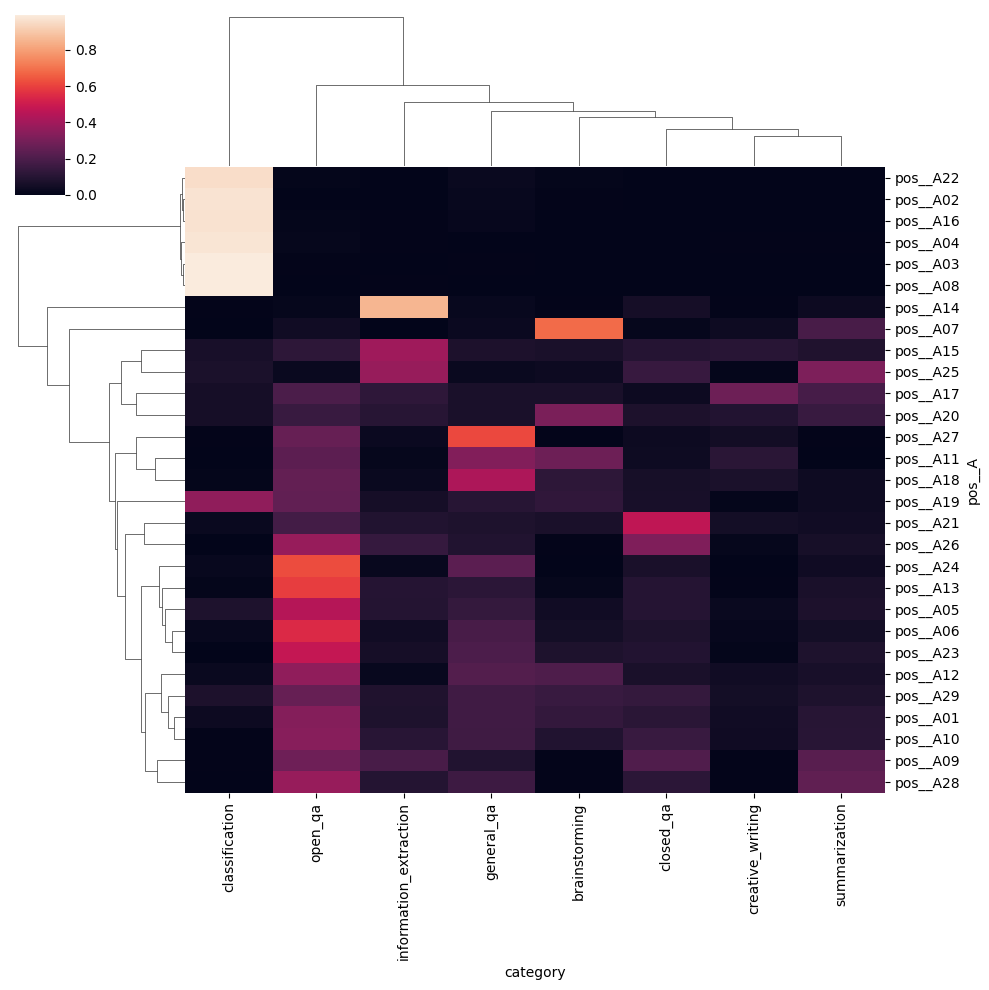

In [41]:
import seaborn as sns
sns.clustermap(pos_xtab_norm) 
# A22, A02, A16, A04, A03, A08, A14 are 95%+ classification, 
# A14 is information extraction
# A07 is 2/3 brainstorming

In [32]:
cluster_cols = [col for col in dolly_data2.columns if 'pos__' in col]
keep_cols = ['instruction', 'instruction_parsified', 'category', *cluster_cols]
minidd = dolly_data2[dolly_data2['pos__A'] != 'pos__A29'].sort_values(cluster_cols)[keep_cols]
minidd.to_excel('dolly_data_clustered_by_pos_vectors.xlsx')
minidd

,instruction,instruction_parsified,category,pos__A,pos__B,pos__C,pos__D,pos__E,pos__F,pos__G,pos__H
689,"Tell me whether these cities are in Minnesota,...",verb_root dobj_pron sconj_mark det nsubj_noun ...,classification,pos__A01,pos__B001,pos__C001,pos__D001,pos__E0001,pos__F0001,pos__G0001,pos__H0001
5249,Tell me whether these characters are from Harr...,verb_root dobj_pron sconj_mark det nsubj_noun ...,classification,pos__A01,pos__B001,pos__C001,pos__D001,pos__E0001,pos__F0001,pos__G0001,pos__H0001
384,Which of the following are ice cream toppings ...,nsubj_pron prep_adp det verb_pobj aux_root nou...,classification,pos__A01,pos__B001,pos__C001,pos__D001,pos__E0002,pos__F0002,pos__G0002,pos__H0002
8346,which of the following are software companies ...,nsubj_pron prep_adp det verb_pobj aux_root nou...,classification,pos__A01,pos__B001,pos__C001,pos__D001,pos__E0002,pos__F0002,pos__G0002,pos__H0003
8488,Which numbers between 1 to 10 are prime number...,det nsubj_noun prep_adp num_quantmod quantmod_...,classification,pos__A01,pos__B001,pos__C001,pos__D001,pos__E0002,pos__F0002,pos__G0003,pos__H0004
...,...,...,...,...,...,...,...,...,...,...,...
1344,What is a Romance language?,attr_pron aux_root det compound_propn nsubj_no...,open_qa,pos__A28,pos__B083,pos__C129,pos__D229,pos__E0563,pos__F1400,pos__G2345,pos__H3084
7792,What was the Bismarck battleship?,attr_pron aux_root det compound_propn nsubj_no...,information_extraction,pos__A28,pos__B083,pos__C129,pos__D229,pos__E0563,pos__F1400,pos__G2345,pos__H3084
3268,What is a Put option in finance?,attr_pron aux_root det compound_propn nsubj_no...,open_qa,pos__A28,pos__B083,pos__C129,pos__D229,pos__E0563,pos__F1400,pos__G2345,pos__H3085
10252,Based on the following paragraph on astrobiolo...,verb_prep prep_adp det verb_amod pobj_noun pre...,closed_qa,pos__A28,pos__B083,pos__C129,pos__D229,pos__E0563,pos__F1400,pos__G2346,pos__H3086
